# Modelo com Rebalanceamento e Custos de Transação 

In [8]:
import pandas as pd
import numpy as np
import random
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.environ import SolverFactory
import yfinance as yf
import matplotlib.pyplot as plt

In [27]:
# lista_ativos = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA', 'WEGE3.SA',
#        'B3SA3.SA', 'BBAS3.SA', 'RENT3.SA', 'PRIO3.SA', 'SUZB3.SA', 'GGBR4.SA',
#        'CSNA3.SA', 'GOAU4.SA', 'RADL3.SA', 'ENEV3.SA', 'EQTL3.SA', 'FLRY3.SA',
#        'HAPV3.SA', 'MGLU3.SA', '^BVSP']

lista_ativos = [
'ABEV3.SA',
'ASAI3.SA',
'AZUL4.SA',
'B3SA3.SA',
'BBAS3.SA',
'BBDC3.SA',
'BBDC4.SA',
'BBSE3.SA',
'BEEF3.SA',
'BPAC11.SA',
'BRAP4.SA',
'BRFS3.SA',
'BRKM5.SA',
'CCRO3.SA',
'CIEL3.SA',
'CMIG4.SA',
'COGN3.SA',
'CPFE3.SA',
'CPLE6.SA',
'CRFB3.SA',
'CSAN3.SA',
'CSNA3.SA',
'CVCB3.SA',
'CYRE3.SA',
'ECOR3.SA',
'EGIE3.SA',
'ELET3.SA',
'ELET6.SA',
'EMBJ3.SA',
'ENEV3.SA',
'ENGI11.SA',
'EQTL3.SA',
'EZTC3.SA',
'FLRY3.SA',
'GGBR4.SA',
'GOAU4.SA',
'GOLL4.SA',
'HAPV3.SA',
'HYPE3.SA',
'IRBR3.SA',
'ITSA4.SA',
'ITUB4.SA',
'JBSS3.SA',
'JHSF3.SA',
'KLBN11.SA',
'LREN3.SA',
'MGLU3.SA',

]

# lista_ativos = random.sample(lista_ativos,20)

print("-----------COMEÇANDO---------")


#DADOS DOS ATIVOS
mydf = pd.DataFrame()
for ativo in lista_ativos:
    mydf[ativo] = yf.download(ativo, period="1y")["Close"]

retornos_ativos = (mydf / mydf.shift(1))-1

#DADOS DO IBOV
mydf_ibov = pd.DataFrame()
mydf_ibov['IBOV'] = yf.download('^BVSP', period="1y")["Close"]


retorno_ibov = (mydf_ibov / mydf_ibov.shift(1)) - 1



#--------------- MANUS CONSERTANDO
# DICA: Remova os NaNs que o shift(1) cria na primeira linha
# retornos_ativos = retornos_ativos.dropna()
# retorno_ibov = retorno_ibov.dropna()

# Alinhando os dados para garantir que tenham o mesmo número de linhas
common_index = retornos_ativos.index.intersection(retorno_ibov.index)
# retornos_ativos = retornos_ativos.loc[common_index]
# retorno_ibov = retorno_ibov.loc[common_index]

-----------COMEÇANDO---------


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
$BRFS3.SA: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRFS3.SA']: possibly delisted; 

In [39]:
retorno_ibov = retorno_ibov.loc[common_index]
retornos_ativos = retornos_ativos.loc[common_index]
metade_ativo = len(retornos_ativos)//2
metade_ibov = len(retorno_ibov)//2

In [159]:
# Metades Atvios
retornos_ativos_primeira_metade = retornos_ativos.iloc[0:metade_ativo]
retornos_ativos_primeira_metade = retornos_ativos_primeira_metade.dropna(axis=1, how='all').dropna(axis=0, how='all')
retornos_ativos_segunda_metade = retornos_ativos.iloc[metade_ativo:]
retornos_ativos_segunda_metade = retornos_ativos_segunda_metade.dropna(axis=1, how='all').dropna(axis=0, how='all')

# Metade ibov
retornos_ibov_primeira_metade = retorno_ibov.iloc[0:metade_ibov]
retornos_ibov_primeira_metade = retornos_ibov_primeira_metade.dropna(axis=1, how='all').dropna(axis=0, how='all')
retornos_ibov_segunda_metade = retorno_ibov.iloc[metade_ibov:]
retornos_ibov_segunda_metade = retornos_ibov_segunda_metade.dropna(axis=1, how='all').dropna(axis=0, how='all')





In [151]:
# ------ CRIAÇÃO DO MODELO
model = pyo.ConcreteModel()

# Definir RangeSet que serão usados para fazer o For
# "A" para quantidade de ativos, virão da quantidade de colunas len(.columns)
# "T" para quantidade de dias analisados, que podem ser observados pela quantidade de linhas len()
model.A = pyo.RangeSet(0, len(retornos_ativos_primeira_metade.columns)-1)
model.T = pyo.RangeSet(0, len(retornos_ibov_primeira_metade)-1)

# Definição de Parametros (são os Dataframes)
#Quais Df eu tenho? retornos_ativos_primeira_metade e retornos_ibov_primeira_metade
# TEM QUE SER DICIONARIO
# Transformar os df em dicionarios, quando for 2 dimensoes dict[0,1] e 1 dimensão dict[0]
dicio_ativos = {}
for t in range(len(retornos_ativos_primeira_metade)):
    for a in range(len(retornos_ativos_primeira_metade.columns)):
        dicio_ativos[t,a] = retornos_ativos_primeira_metade.iloc[t,a]

dicio_ibov = {}
for t in range(len(retornos_ibov_primeira_metade)):
    dicio_ibov[t] = retornos_ibov_primeira_metade['IBOV'].iloc[t]


model.ATIVOS_PRIMEIRA_METADE = pyo.Param(model.T,model.A, initialize = dicio_ativos)
model.IBOV_PRIMEIRA_METADE = pyo.Param(model.T, initialize = dicio_ibov)

# Definicindo as variáveis
# nesse projeto será feito a mesma coisa do que o mip com restrição de cardinalidade, 
# mas será feito primeiro na primeira metade, e após será feito o rebalanceamento
#variavel x para peso, y para cardinalidade

model.x = pyo.Var(model.A, bounds=(0,1))
model.y = pyo.Var(model.A, within=pyo.Binary)

# Definindo função objetivo
# a ideia na primeira parte é reduzir o erro quadrático
def func_objetivo_1(model):
    return sum(
        (sum(model.ATIVOS_PRIMEIRA_METADE[t,a] * model.x[a] for a in model.A) - model.IBOV_PRIMEIRA_METADE[t])**2 for t in model.T
    )
model.obj1 = pyo.Objective(rule=func_objetivo_1, sense=pyo.minimize)

# Restrições
# soma dos pesos tem que ser igual a 1
# se y for 0 x nao é para ser 0 
#observar as dicas para, regras globais e regras individuais, 
# regra individual: peso maximo para cada ativo é 0.12
# regra global, a soma dos pesos é 1

#REstricao 1 x só ativa se y = 1
def restr_vinculo_x_y(model, a):
    return model.x[a] <= model.y[a]
model.restr_vinculo_x_y = pyo.Constraint(model.A, rule=restr_vinculo_x_y)

#Restrição 2 soma peso 1
def soma_peso_1(model):
    return sum(model.x[a] for a in model.A) ==1
model.soma_peso_1 = pyo.Constraint(rule=soma_peso_1)

#Restrição 3 de cardinalidade, quantidade de ativos no total
def cardinalidade_15(model):
    return sum(model.y[a] for a in model.A) == 15
model.cardinalidade_15 = pyo.Constraint(rule=cardinalidade_15)

opt = SolverFactory('cplex', executable='C:\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe')
resultado = opt.solve(model)
print("-------FIM----------")

-------FIM----------


In [162]:
lsita_grande = []
for numero in range(len(retornos_ativos_primeira_metade.columns)):
    peso_ativo = pyo.value(model.x[numero])
    ativado = pyo.value(model.y[numero])
    lista = [peso_ativo, ativado]
    lsita_grande.append(lista)
    
final = pd.DataFrame(lsita_grande, columns=["peso_ativo","ativado"], index=retornos_ativos_primeira_metade.columns)
print(final[final['ativado']==1])

           peso_ativo  ativado
AZUL4.SA     0.016038      1.0
B3SA3.SA     0.032725      1.0
BBAS3.SA     0.035826      1.0
BBDC3.SA     0.053649      1.0
BEEF3.SA     0.029100      1.0
BPAC11.SA    0.038940      1.0
BRAP4.SA     0.186729      1.0
CMIG4.SA     0.112038      1.0
EQTL3.SA     0.128796      1.0
EZTC3.SA     0.027736      1.0
GOAU4.SA     0.040128      1.0
HYPE3.SA     0.036555      1.0
ITUB4.SA     0.173827      1.0
KLBN11.SA    0.044460      1.0
LREN3.SA     0.043452      1.0


In [163]:
df_final = final[final['ativado']==1]
# df_final.head()
ativos_selecionados = df_final.index
retornos_carteira= retornos_ativos_primeira_metade[ativos_selecionados]

carteira_otimizada = (retornos_carteira*df_final['peso_ativo']).sum(axis=1)
carteira_otimizada = 1 + carteira_otimizada
#criar a carteira equiponderada, com pesos iguais

carteira_equi = retornos_carteira.mean(axis=1)
carteira_equi = 1 + carteira_equi

107.3415215897745
97.22896077715303
105.59504826838636


C:\Users\DECIV\AppData\Local\Temp\ipykernel_16944\3421782161.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_otimizado[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_16944\3421782161.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_equi[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_16944\3421782161.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_ibov[-1])


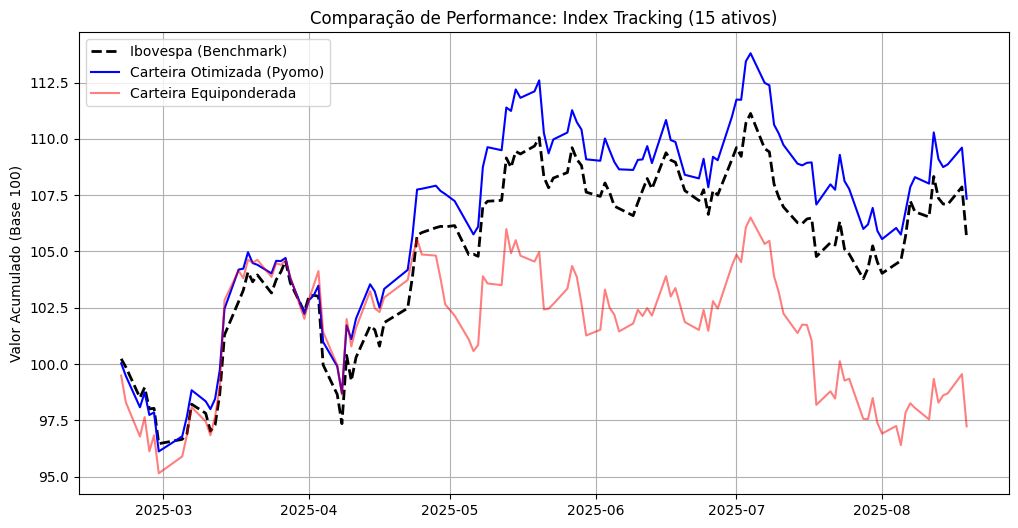

In [165]:
# 3. Transformar em Retorno Acumulado (Base 100)
acum_otimizado = (carteira_otimizada).cumprod() * 100
acum_equi = (carteira_equi).cumprod() * 100
acum_ibov = (1 + retornos_ibov_primeira_metade['IBOV']).cumprod() * 100

print(acum_otimizado[-1])
print(acum_equi[-1])
print(acum_ibov[-1])

# 4. Plotar o Gráfico
plt.figure(figsize=(12, 6))
plt.plot(acum_ibov, label='Ibovespa (Benchmark)', color='black', linewidth=2, linestyle='--')
plt.plot(acum_otimizado, label='Carteira Otimizada (Pyomo)', color='blue')
plt.plot(acum_equi, label='Carteira Equiponderada', color='red', alpha=0.5)

plt.title('Comparação de Performance: Index Tracking (15 ativos)')
plt.ylabel('Valor Acumulado (Base 100)')
plt.legend()
plt.grid(True)
plt.show()

### -------- 2º parte -  REBALANCEAMENTO

In [173]:
pesos_anteriores = {a: pyo.value(model.x[a]) for a in model.A}